In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set a seed for reproducibility
np.random.seed(42)

num_qubits = 15
dev = qml.device("default.qubit", wires=num_qubits)
gate_set = [qml.RX, qml.RY, qml.RZ]


def rand_circuit(params, random_gate_sequence=None, num_qubits=None):
    """A random variational quantum circuit.

    Args:
        params (array[float]): array of parameters
        random_gate_sequence (dict): a dictionary of random gates
        num_qubits (int): the number of qubits in the circuit

    Returns:
        float: the expectation value of the target observable
    """
    for i in range(num_qubits):
        qml.RY(np.pi / 4, wires=i)

    for i in range(num_qubits):
        random_gate_sequence[i](params[i], wires=i)

    for i in range(num_qubits - 1):
        qml.CZ(wires=[i, i + 1])

    H = np.zeros((2 ** num_qubits, 2 ** num_qubits))
    H[0, 0] = 1
    wirelist = [i for i in range(num_qubits)]
    return qml.expval(qml.Hermitian(H, wirelist))

In [3]:
grad_vals = []
grad_vals_last = []
num_samples = 200

for i in range(num_samples):
    gate_sequence = {i: np.random.choice(gate_set) for i in range(num_qubits)}
    qcircuit = qml.QNode(rand_circuit, dev, interface="autograd")
    grad = qml.grad(qcircuit, argnum=0)
    params = np.random.uniform(0, 2 * np.pi, size=num_qubits)
    gradient = grad(params, random_gate_sequence=gate_sequence, num_qubits=num_qubits)
    grad_vals.append(gradient)
    grad_vals_last.append(gradient[-1])

: 

In [ ]:
grad_vals = np.linalg.norm(grad_vals, axis=1)

In [ ]:
mean_norm = np.mean(grad_vals)
var_norm = np.var(grad_vals)

In [ ]:
print("Mean norm of gradient: ", mean_norm)
print("Variance of norm of gradient: ", var_norm)

Mean norm of gradient:  0.01153938574691131
Variance of norm of gradient:  0.0004296106170491015


In [ ]:
print("Variance of the gradients for {} random circuits: {}".format(
    num_samples, np.var(grad_vals_last)
    )
)
print("Mean of the gradients for {} random circuits: {}".format(
    num_samples, np.mean(grad_vals_last)
    )
)

Variance of the gradients for 200 random circuits: 7.177570924624978e-05
Mean of the gradients for 200 random circuits: -0.0002190741274578915


In [ ]:
qubits = [2, 3, 4, 5, 6]
variances_norm = []
variance = []


for num_qubits in qubits:
    grad_vals = []
    grad_last_val = []
    for i in range(num_samples):
        dev = qml.device("default.qubit", wires=num_qubits)
        qcircuit = qml.QNode(rand_circuit, dev, interface="autograd")
        grad = qml.grad(qcircuit, argnum=0)

        gate_set = [qml.RX, qml.RY, qml.RZ]
        random_gate_sequence = {i: np.random.choice(gate_set) for i in range(num_qubits)}

        params = np.random.uniform(0, np.pi, size=num_qubits)
        gradient = grad(
            params, random_gate_sequence=random_gate_sequence, num_qubits=num_qubits
        )
        grad_vals.append(np.linalg.norm(gradient, axis=0))
        grad_last_val.append(gradient[-1])
    variances_norm.append(np.var(grad_vals))
    variance.append(np.var(grad_last_val))

variances_norm = np.array(variances_norm)
qubits = np.array(qubits)
variance = np.array(variance)

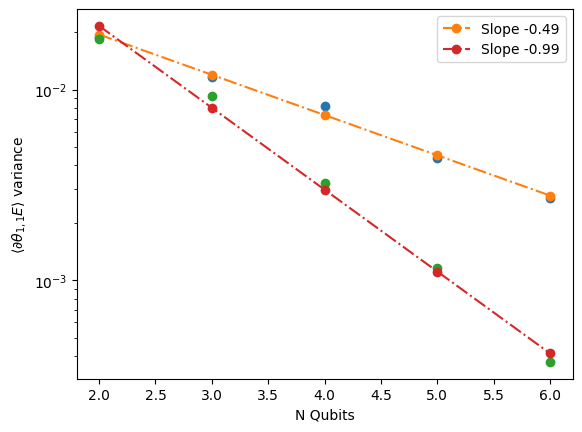

In [ ]:
# Fit the semilog plot to a straight line
p = np.polyfit(qubits, np.log(variances_norm), 1)
y = np.polyfit(qubits, np.log(variance), 1)


# Plot the straight line fit to the semilog
plt.semilogy(qubits, variances_norm, "o")
plt.semilogy(qubits, np.exp(p[0] * qubits + p[1]), "o-.", label="Slope {:3.2f}".format(p[0]))
plt.semilogy(qubits, variance, "o")
plt.semilogy(qubits, np.exp(y[0] * qubits + y[1]), "o-.", label="Slope {:3.2f}".format(y[0]))
plt.xlabel(r"N Qubits")
plt.ylabel(r"$\langle \partial \theta_{1, 1} E\rangle$ variance")
plt.legend()
plt.show()